<a href="https://colab.research.google.com/github/nctamer/paganini/blob/main/alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@markdown Import modules
!pip install numba==0.53    &> /dev/null
!pip install synctoolbox    &> /dev/null
!pip install libfmp    &> /dev/null
!git clone https://github.com/nctamer/violin-etudes.git   &> /dev/null
!pip install libf0   &> /dev/null
!pip install yt-dlp   &> /dev/null
from IPython.display import YouTubeVideo
import librosa
import IPython.display as ipd
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import DataLoader
import random
import numpy as np
import librosa
from librosa.sequence import viterbi_discriminative
import sys, math
import glob
import time
import numpy as np
import matplotlib.image as mpimg
from tqdm import tqdm
from pathlib import Path
import os
from scipy.stats import norm
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import libf0

def plot_f0_trajectory(Y_LF, t, f, f0, t_f0, figsize=(8.5, 3.4), xlim=(0, 11.5), ylim=(2000, 6000)):
    """
    Plot a calculated f0 trajectory on the corresponding spectrogram
    
    Parameters
    ----------
    Y_LF : np.ndarray
        log-frequency spectrogram
    t : np.ndarray
        time axis of the spectrogram
    f : np.ndarray
        log-frequency axis of the spectrogram in cents
    f0 : np.ndarray
        f0 trajectory in cents
    t_f0 : np.ndarray
        time points of the f0 trajectory frames
    figsize : tuple
        figure size
    xlim : tuple
        x-limits
    ylim : tuple
        y-limits
    """
    plt.figure(figsize=figsize)

    plt.imshow(Y_LF, cmap='gray_r', aspect='auto', origin='lower', extent=[t[0], t[-1], f[0], f[-1]])
    plt.plot(t_f0, f0, linestyle='', marker='.', markersize=5, color=[192/256, 0, 0])

    plt.xlim(xlim)
    plt.ylim(ylim)

    plt.gca().tick_params(axis='both', which='major', labelsize=10)
    plt.gca().tick_params(axis='both', which='minor', labelsize=10)
    
    plt.xlabel("Time (seconds)", fontsize=12)
    plt.ylabel("Log-Frequency (cents)", fontsize=12)
    
    cbar = plt.colorbar()
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('Log-Magnitude', rotation=270)

    plt.tight_layout()
    plt.show()

# Alignment for the selected recordings.
TODO:
- CQT instead of Chroma
- Automatic downloads
- Better f0 estimation 

## Download the following playlists (6 samples per caprice):

In [15]:
!yt-dlp --yes-playlist https://www.youtube.com/playlist?list=PLJTogM3HqLItI9ax9MWlyOeZeiuXPgEqF  -x --audio-format wav --audio-quality 0  -i -o "violin-etudes/audio/PaganiniOp1/No%(playlist_index)02d/AntalZalai_%(title)s_[%(id)s]_0000_%(duration)04d.%(ext)s"
!yt-dlp --yes-playlist https://youtube.com/playlist?list=PLwLTvGAP00b-5A_pVbkxg8yk6g7anXik7  -x --audio-format wav --audio-quality 0  -i -o "violin-etudes/audio/PaganiniOp1/No%(playlist_index)02d/AlicanSuener_%(title)s_[%(id)s]_0000_%(duration)04d.%(ext)s"
!yt-dlp --yes-playlist https://www.youtube.com/playlist?list=PLfXppYtrZclQ52OgzSFu2cxSSwZDseigJ  -x --audio-format wav --audio-quality 0  -i -o "violin-etudes/audio/PaganiniOp1/No%(playlist_index)02d/ItzhakPerlman_%(title)s_[%(id)s]_0000_%(duration)04d.%(ext)s"
!yt-dlp --yes-playlist https://youtube.com/playlist?list=PL7UqW2VticVLXyKCpmNqH1Nwmi4xu3qSI  -x --audio-format wav --audio-quality 0  -i -o "violin-etudes/audio/PaganiniOp1/No%(playlist_index)02d/JuliaFischer_%(title)s_[%(id)s]_0000_%(duration)04d.%(ext)s"
!yt-dlp --yes-playlist https://www.youtube.com/playlist?list=PLn2--CWCjouOuWOprzNkaYKJ0g7FFMbce  -x --audio-format wav --audio-quality 0  -i -o "violin-etudes/audio/PaganiniOp1/No%(playlist_index)02d/InmoYang_%(title)s_[%(id)s]_0000_%(duration)04d.%(ext)s"
!yt-dlp --yes-playlist https://youtube.com/playlist?list=PLdkjwZMK_CIqA7ZUWb7KOLEKrwahwRtVI  -x --audio-format wav --audio-quality 0  -i -o "violin-etudes/audio/PaganiniOp1/No%(playlist_index)02d/SalvatoreAccardo_%(title)s_[%(id)s]_0000_%(duration)04d.%(ext)s"
!yt-dlp --yes-playlist https://www.youtube.com/playlist?list=PLIK4KBELyc3BCeHp9G2HqloTUqAFt8AgB  -x --audio-format wav --audio-quality 0  -i -o "violin-etudes/audio/PaganiniOp1/No%(playlist_index)02d/IlyaKaler_%(title)s_[%(id)s]_0000_%(duration)04d.%(ext)s"


[youtube:tab] Extracting URL: https://www.youtube.com/playlist?list=PLJTogM3HqLItI9ax9MWlyOeZeiuXPgEqF
[youtube:tab] PLJTogM3HqLItI9ax9MWlyOeZeiuXPgEqF: Downloading webpage
[youtube:tab] PLJTogM3HqLItI9ax9MWlyOeZeiuXPgEqF: Redownloading playlist API JSON with unavailable videos
[download] Downloading playlist: PAGANINI: 24 Caprices (complete) Antal Zalai 🎵 violin 🎵 classical music
[youtube:tab] Playlist PAGANINI: 24 Caprices (complete) Antal Zalai 🎵 violin 🎵 classical music: Downloading 24 items of 24
[download] Downloading item 1 of 24
[youtube] Extracting URL: https://www.youtube.com/watch?v=lrrPSBjb1qg
[youtube] lrrPSBjb1qg: Downloading webpage
[youtube] lrrPSBjb1qg: Downloading android player API JSON
[info] lrrPSBjb1qg: Downloading 1 format(s): 251
[download] violin-etudes/audio/PaganiniOp1/No01/AntalZalai_PAGANINI： Caprice No. 1 ｜ Antal Zalai, violin 🎵 classical music_[lrrPSBjb1qg]_0000_0109.wav has already been downloaded
[ExtractAudio] Destination: violin-etudes/audio/PaganiniO

In [9]:
#@markdown write score_informed_pitch_detection.py 
%%writefile score_informed_pitch_detection.py
import numpy as np
from scipy import linalg
import libfmp.c8
from matplotlib import pyplot as plt
import matplotlib


def hz_to_cents(F, F_ref=55.0):
    """Converts frequency in Hz to cents

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        F (float or np.ndarray): Frequency value in Hz
        F_ref (float): Reference frequency in Hz (Default value = 55.0)

    Returns:
        F_cent (float or np.ndarray): Frequency in cents
    """
    F_cent = 1200 * np.log2(F / F_ref)
    return F_cent

def cents_to_hz(F_cent, F_ref=55.0):
    """Converts frequency in cents to Hz

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        F_cent (float or np.ndarray): Frequency in cents
        F_ref (float): Reference frequency in Hz (Default value = 55.0)

    Returns:
        F (float or np.ndarray): Frequency in Hz
    """
    F = F_ref * 2 ** (F_cent / 1200)
    return F


def define_transition_matrix(B, tol=0, score_low=0.01, score_high=1.0):
    """Generate transition matrix

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        B (int): Number of bins
        tol (int): Tolerance parameter for transition matrix (Default value = 0)
        score_low (float): Score (low) for transition matrix (Default value = 0.01)
        score_high (float): Score (high) for transition matrix (Default value = 1.0)

    Returns:
        T (np.ndarray): Transition matrix
    """
    col = np.ones((B,)) * score_low
    col[0:tol+1] = np.ones((tol+1, )) * score_high
    T = linalg.toeplitz(col)
    return T

def convert_ann_to_constraint_region(ann, tol_freq_cents=300.0):
    """Convert score annotations to constraint regions

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        ann (list): Score annotations [[start_time, end_time, MIDI_pitch], ...
        tol_freq_cents (float): Tolerance in pitch directions specified in cents (Default value = 300.0)

    Returns:
        constraint_region (np.ndarray): Constraint regions
    """
    tol_pitch = tol_freq_cents / 100
    freq_lower = 2 ** ((ann[:, 2] - tol_pitch - 69)/12) * 440
    freq_upper = 2 ** ((ann[:, 2] + tol_pitch - 69)/12) * 440
    constraint_region = np.concatenate((ann[:, 0:2],
                                        freq_lower.reshape(-1, 1),
                                        freq_upper.reshape(-1, 1)), axis=1)
    return constraint_region


def compute_trajectory_dp(Z, T):
    """Trajectory tracking using dynamic programming

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        Z: Salience representation
        T: Transisition matrix

    Returns:
        eta_DP (np.ndarray): Trajectory indices
    """
    B, N = Z.shape
    eps_machine = np.finfo(np.float32).eps
    Z_log = np.log(Z + eps_machine)
    T_log = np.log(T + eps_machine)

    E = np.zeros((B, N))
    D = np.zeros((B, N))
    D[:, 0] = Z_log[:, 0]

    for n in np.arange(1, N):
        for b in np.arange(0, B):
            D[b, n] = np.max(T_log[b, :] + D[:, n-1]) + Z_log[b, n]
            E[b, n-1] = np.argmax(T_log[b, :] + D[:, n-1])

    # backtracking
    eta_DP = np.zeros(N)
    eta_DP[N-1] = int(np.argmax(D[:, N-1]))

    for n in np.arange(N-2, -1, -1):
        eta_DP[n] = E[int(eta_DP[n+1]), n]

    return eta_DP.astype(np.int64)


def compute_trajectory_cr(Z, T_coef, F_coef_hertz, constraint_region=None,
                          tol=5, score_low=0.01, score_high=1.0):
    """Trajectory tracking with constraint regions

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        Z (np.ndarray): Salience representation
        T_coef (np.ndarray): Time axis
        F_coef_hertz (np.ndarray): Frequency axis in Hz
        constraint_region (np.ndarray): Constraint regions, row-format: (t_start_sec, t_end_sec, f_start_hz, f_end_hz)
            (Default value = None)
        tol (int): Tolerance parameter for transition matrix (Default value = 5)
        score_low (float): Score (low) for transition matrix (Default value = 0.01)
        score_high (float): Score (high) for transition matrix (Default value = 1.0)

    Returns:
        eta (np.ndarray): Trajectory indices, unvoiced frames are indicated with -1
    """
    # do tracking within every constraint region
    if constraint_region is not None:
        # initialize contour, unvoiced frames are indicated with -1
        eta = np.full(len(T_coef), -1)

        for row_idx in range(constraint_region.shape[0]):
            t_start = constraint_region[row_idx, 0]  # sec
            t_end = constraint_region[row_idx, 1]  # sec
            f_start = constraint_region[row_idx, 2]  # Hz
            f_end = constraint_region[row_idx, 3]  # Hz

            # convert start/end values to indices
            t_start_idx = np.argmin(np.abs(T_coef - t_start))
            t_end_idx = np.argmin(np.abs(T_coef - t_end))
            f_start_idx = np.argmin(np.abs(F_coef_hertz - f_start))
            f_end_idx = np.argmin(np.abs(F_coef_hertz - f_end))

            # track in salience part
            cur_Z = Z[f_start_idx:f_end_idx+1, t_start_idx:t_end_idx+1]
            T = define_transition_matrix(cur_Z.shape[0], tol=tol,
                                         score_low=score_low, score_high=score_high)
            cur_eta = compute_trajectory_dp(cur_Z, T)

            # fill contour
            eta[t_start_idx:t_end_idx+1] = f_start_idx + cur_eta
    else:
        T = define_transition_matrix(Z.shape[0], tol=tol, score_low=score_low, score_high=score_high)
        eta = compute_trajectory_dp(Z, T)

    return eta


def compute_traj_from_audio(x, Fs=22050, N=1024, H=128, R=10.0, F_min=55.0, F_max=1760.0,
                            num_harm=10, freq_smooth_len=11, alpha=0.9, gamma=0.0,
                            constraint_region=None, tol=5, score_low=0.01, score_high=1.0):
    """Compute F0 contour from audio signal

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        x (np.ndarray): Audio signal
        Fs (scalar): Sampling frequency (Default value = 22050)
        N (int): Window length in samples (Default value = 1024)
        H (int): Hopsize in samples (Default value = 128)
        R (float): Frequency resolution in cents (Default value = 10.0)
        F_min (float): Lower frequency bound (reference frequency) (Default value = 55.0)
        F_max (float): Upper frequency bound (Default value = 1760.0)
        num_harm (int): Number of harmonics (Default value = 10)
        freq_smooth_len (int): Filter length for vertical smoothing (Default value = 11)
        alpha (float): Weighting parameter for harmonics (Default value = 0.9)
        gamma (float): Logarithmic compression factor (Default value = 0.0)
        constraint_region (np.ndarray): Constraint regions, row-format: (t_start_sec, t_end_sec, f_start_hz, f_end,hz)
            (Default value = None)
        tol (int): Tolerance parameter for transition matrix (Default value = 5)
        score_low (float): Score (low) for transition matrix (Default value = 0.01)
        score_high (float): Score (high) for transition matrix (Default value = 1.0)

    Returns:
        traj (np.ndarray): F0 contour, time in seconds in 1st column, frequency in Hz in 2nd column
        Z (np.ndarray): Salience representation
        T_coef (np.ndarray): Time axis
        F_coef_hertz (np.ndarray): Frequency axis in Hz
        F_coef_cents (np.ndarray): Frequency axis in cents
    """
    Z, F_coef_hertz, F_coef_cents = libfmp.c8.compute_salience_rep(
        x, Fs, N=N, H=H, R=R, F_min=F_min, F_max=F_max, num_harm=num_harm, freq_smooth_len=freq_smooth_len,
        alpha=alpha, gamma=gamma)

    T_coef = (np.arange(Z.shape[1]) * H) / Fs
    index_CR = compute_trajectory_cr(Z, T_coef, F_coef_hertz, constraint_region,
                                     tol=tol, score_low=score_low, score_high=score_high)

    traj = np.hstack((T_coef.reshape(-1, 1), F_coef_hertz[index_CR].reshape(-1, 1)))
    traj[index_CR == -1, 1] = 0
    return traj, Z, T_coef, F_coef_hertz, F_coef_cents


def visualize_salience_traj_constraints(Z, T_coef, F_coef_cents, F_ref=55.0, colorbar=True, cmap='gray_r',
                                        figsize=(7, 4), traj=None, constraint_region=None, ax=None):
    """Visualize salience representation with optional F0-trajectory and constraint regions

    Notebook: C8/C8S2_FundFreqTracking.ipynb

    Args:
        Z: Salience representation
        T_coef: Time axis
        F_coef_cents: Frequency axis in cents
        F_ref: Reference frequency (Default value = 55.0)
        colorbar: Show or hide colorbar (Default value = True)
        cmap: Color map (Default value = 'gray_r')
        figsize: Figure size (Default value = (7, 4))
        traj: F0 trajectory (time in seconds, frequency in Hz) (Default value = None)
        constraint_region: Constraint regions, row-format: (t_start_sec, t_end_sec, f_start_hz, f_end,hz)
            (Default value = None)
        ax: Handle to existing axis (Default value = None)

    Returns:
        fig: Handle to figure
        ax: Handle to cent axis
        ax_f: Handle to frequency axis
    """
    fig = None
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    sal = ax.imshow(Z, extent=[T_coef[0], T_coef[-1], F_coef_cents[0], F_coef_cents[-1]],
                    cmap=cmap, origin='lower', aspect='auto', interpolation='nearest')

    y_ticklabels_left = np.arange(F_coef_cents[0], F_coef_cents[-1]+1, 1200)
    ax.set_yticks(y_ticklabels_left)
    ax.set_yticklabels(y_ticklabels_left)
    ax.set_ylabel('Frequency (Cents)')

    if colorbar:
        plt.colorbar(sal, ax=ax, pad=0.1)

    ax_f = ax.twinx()  # instantiate a second axes that shares the same y-axis
    ax_f.set_yticks(y_ticklabels_left - F_coef_cents[0])
    y_ticklabels_right = cents_to_hz(y_ticklabels_left, F_ref).astype(int)
    ax_f.set_yticklabels(y_ticklabels_right)
    ax_f.set_ylabel('Frequency (Hz)')

    # plot contour
    if traj is not None:
        traj_plot = traj[traj[:, 1] > 0, :]
        traj_plot[:, 1] = hz_to_cents(traj_plot[:, 1], F_ref)
        ax.plot(traj_plot[:, 0], traj_plot[:, 1], color='r', markersize=4, marker='.', linestyle='')

    # plot constraint regions
    if constraint_region is not None:
        for row in constraint_region:
            t_start = row[0]  # sec
            t_end = row[1]  # sec
            f_start = row[2]  # Hz
            f_end = row[3]  # Hz
            ax.add_patch(matplotlib.patches.Rectangle((
                t_start, hz_to_cents(f_start, F_ref)), width=t_end-t_start,
                height=hz_to_cents(f_end, F_ref)-hz_to_cents(f_start, F_ref),
                fill=False, edgecolor='k', linewidth=3, zorder=2))

    ax.set_xlabel('Time (seconds)')

    if fig is not None:
        plt.tight_layout()

    return fig, ax, ax_f

Writing score_informed_pitch_detection.py


In [13]:
#@markdown Alignment code

import os.path
from libfmp.b import list_to_pitch_activations, plot_chromagram, plot_signal, plot_matrix, \
                     sonify_pitch_activations_with_signal
from libfmp.b import plot_chromagram
import libfmp.c2
from synctoolbox.dtw.mrmsdtw import sync_via_mrmsdtw, sync_via_mrmsdtw_with_anchors
from synctoolbox.dtw.utils import compute_optimal_chroma_shift, shift_chroma_vectors, make_path_strictly_monotonic
from synctoolbox.feature.csv_tools import read_csv_to_df, df_to_pitch_features, df_to_pitch_onset_features
from synctoolbox.feature.chroma import pitch_to_chroma, quantize_chroma, quantized_chroma_to_CENS
from synctoolbox.feature.pitch import audio_to_pitch_features
from synctoolbox.feature.utils import estimate_tuning
import pandas as pd
import numpy as np
import librosa
import librosa.effects
import glob
import copy
from score_informed_pitch_detection import convert_ann_to_constraint_region, visualize_salience_traj_constraints, cents_to_hz, hz_to_cents
import matplotlib.pyplot as plt
import librosa.display
import libf0


Fs = 22050
H = 128
feature_rate = 100
step_weights = np.array([1.5, 1.5, 2.0])
threshold_rec = 10 ** 6

def get_features_from_audio(audio, tuning_offset, visualize=False):  # TODO could make this part of a module
    f_pitch = audio_to_pitch_features(f_audio=audio, Fs=Fs, tuning_offset=tuning_offset, feature_rate=feature_rate,
                                      verbose=visualize)
    f_chroma = pitch_to_chroma(f_pitch=f_pitch)
    f_chroma_quantized = quantize_chroma(f_chroma=f_chroma)
    return f_chroma_quantized


def get_features_from_annotation(df_annotation):
    f_pitch = df_to_pitch_features(df_annotation, feature_rate=feature_rate)
    f_chroma = pitch_to_chroma(f_pitch=f_pitch)
    f_chroma_quantized = quantize_chroma(f_chroma=f_chroma)
    return f_chroma_quantized

def get_corresponding_audio_frame(ann_audio_wp, ann_index, end=False):
    pair = ann_audio_wp[:, ann_audio_wp[0]==ann_index]
    if end:
        return pair[1,-1]
    else:
        return pair[1,0]

def align_csv(midi_csv_path, audio_path, offset=0, duration=None, debug=False):
    # load annotation & get features (as it gets the chroma features of the annotation, I don't feel necessary to convert the MIDI notes to Hz)
    df_ann = pd.read_csv(midi_csv_path, sep=';')  # MIDI info
    df_ann['start'] += 0.1
    df_ann['end'] = df_ann['start'] + df_ann['duration']
    f_ch_ann = get_features_from_annotation(df_ann)

    audio_recording, _ = librosa.load(audio_path, Fs, offset=offset, duration=duration)
    _, start_end_indices = librosa.effects.trim(audio_recording)
    audio_start = max(start_end_indices[0]/Fs, 10*feature_rate/Fs)   # start and end from librosa effects trim
    audio_end = min(start_end_indices[1]/Fs, len(audio_recording)/Fs) # we can also use f0 csv file
    f_ch_recording = get_features_from_audio(audio_recording, estimate_tuning(audio_recording, Fs))
    print('feature extraction successful')
    wp = sync_via_mrmsdtw_with_anchors(f_chroma1=f_ch_ann,
                                       f_chroma2=f_ch_recording,
                                       input_feature_rate=feature_rate,
                                       step_weights=step_weights,
                                       threshold_rec=threshold_rec,
                                       verbose=False,
                                       anchor_pairs=[(0.1, audio_start), (df_ann['end'].max(), audio_end)])
    print('alignment successful')
    # wp_mono = make_path_strictly_monotonic(wp) this is not improving anything
    df_aligned = copy.deepcopy(df_ann)
    for index, annotation in df_ann.iterrows():
        try:
            start = get_corresponding_audio_frame(wp, int(feature_rate*annotation.start))
            end = get_corresponding_audio_frame(wp, int(feature_rate*annotation.end), end=True)
            df_aligned.loc[index, 'start'] = start/feature_rate
            df_aligned.loc[index, 'end'] = end/feature_rate
            df_aligned.loc[index, 'duration'] = (end-start)/feature_rate
        except IndexError:
            print('error in', index, audio_path)


    if debug:
        # Visualization
        figsize = (20, 4)
        cmap = libfmp.b.compressed_gray_cmap(alpha=5)


        ann_score = df_aligned[['start', 'end', 'pitch']].values
        constraint_region = convert_ann_to_constraint_region(ann_score, tol_freq_cents=100)

        # Plot the f0s together with the constraint region
        # shared parameters
        N = 2048 # window size in samples
        H = 256 # hop size in samples
        zero_pad = 2048 # zero-padding for STFT (only for visualization)
        F_min = 55.0 # minimum frequency of interest in Hz
        F_max = 1760.0 # maximum frequency of interest in Hz
        R = 10 # resolution of F0-estimations in cents
        # set parameters
        threshold = 0.2 # confidence threshold between 0 and 1
        x, _ = librosa.load(audio_path, sr=Fs)

        # run the SWIPE algorithm
        f0_swipe, t_swipe, conf_swipe = libf0.swipe(x, Fs, H, F_min, F_max, strength_threshold=threshold)
        f0_content = pd.DataFrame({'time': t_swipe, 'frequency':f0_swipe})
        T_coef = f0_content.time.values
        F_min, F_max = constraint_region[:, 2:].min(), constraint_region[:, 2:].max()

        F_coef_cents = np.arange(hz_to_cents(F_min)-10, hz_to_cents(F_max)+10, 10)
        Z = np.zeros((len(F_coef_cents), len(T_coef)))  # gimmick! we can use the stft instead. this is empty!!

        traj = f0_content.values

        # Visualization
        visualize_salience_traj_constraints(Z, T_coef, F_coef_cents, F_ref=cents_to_hz(F_coef_cents[0]), figsize=figsize, cmap=cmap,
                                            constraint_region=constraint_region, colorbar=False, traj=traj, ax=None)
        plt.title(audio_path)
        plt.show()

    return df_aligned


........................................................................................feature extraction successful
alignment successful


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65306 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65306 missing from current font.
  font.set_text(s, 0, flags=flags)


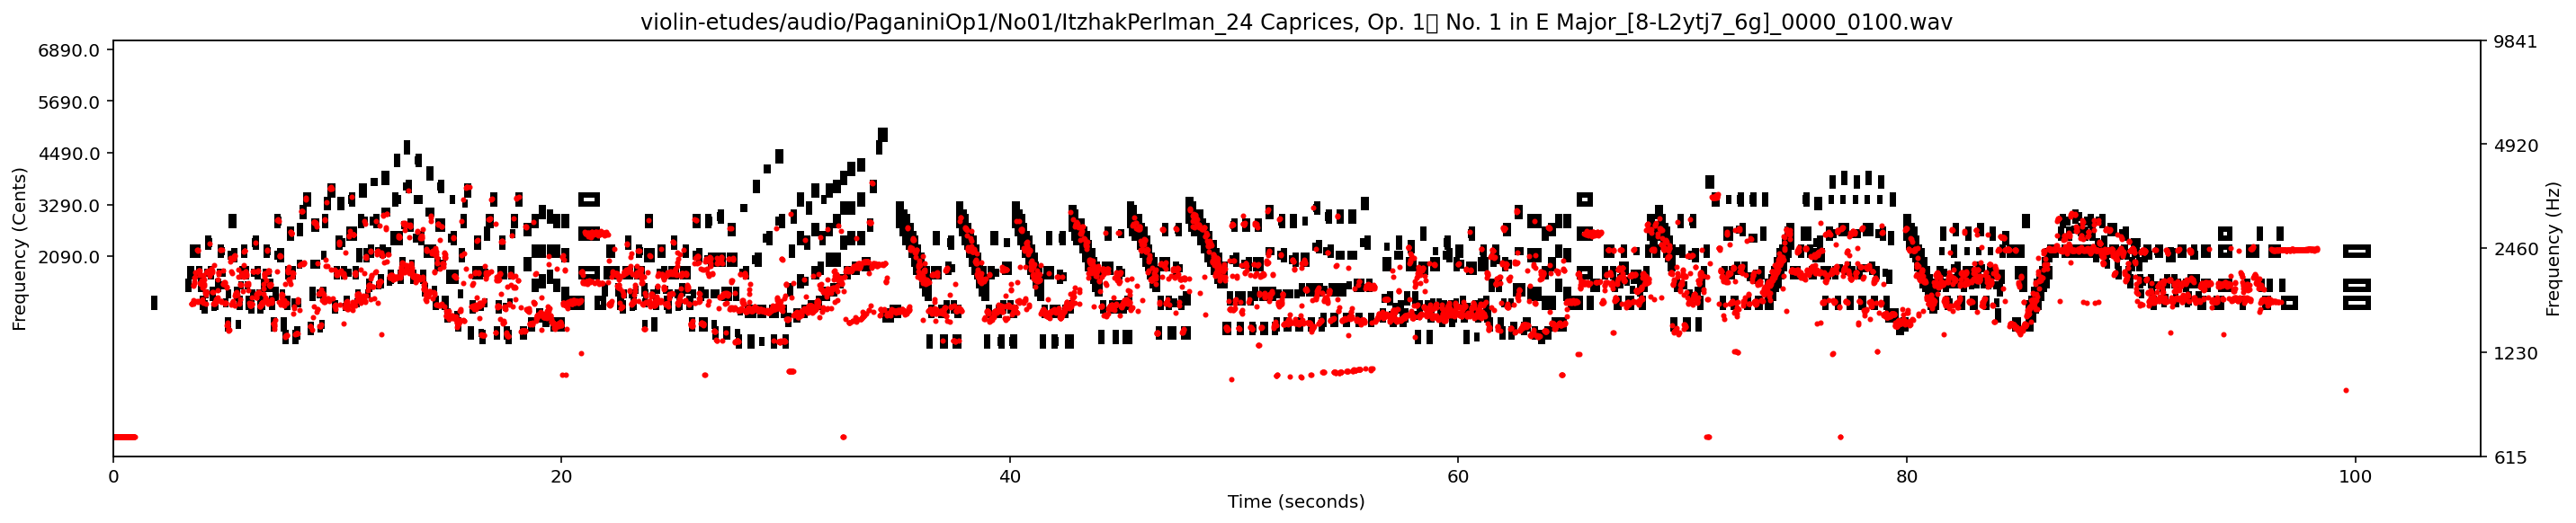

........................................................................................feature extraction successful
alignment successful


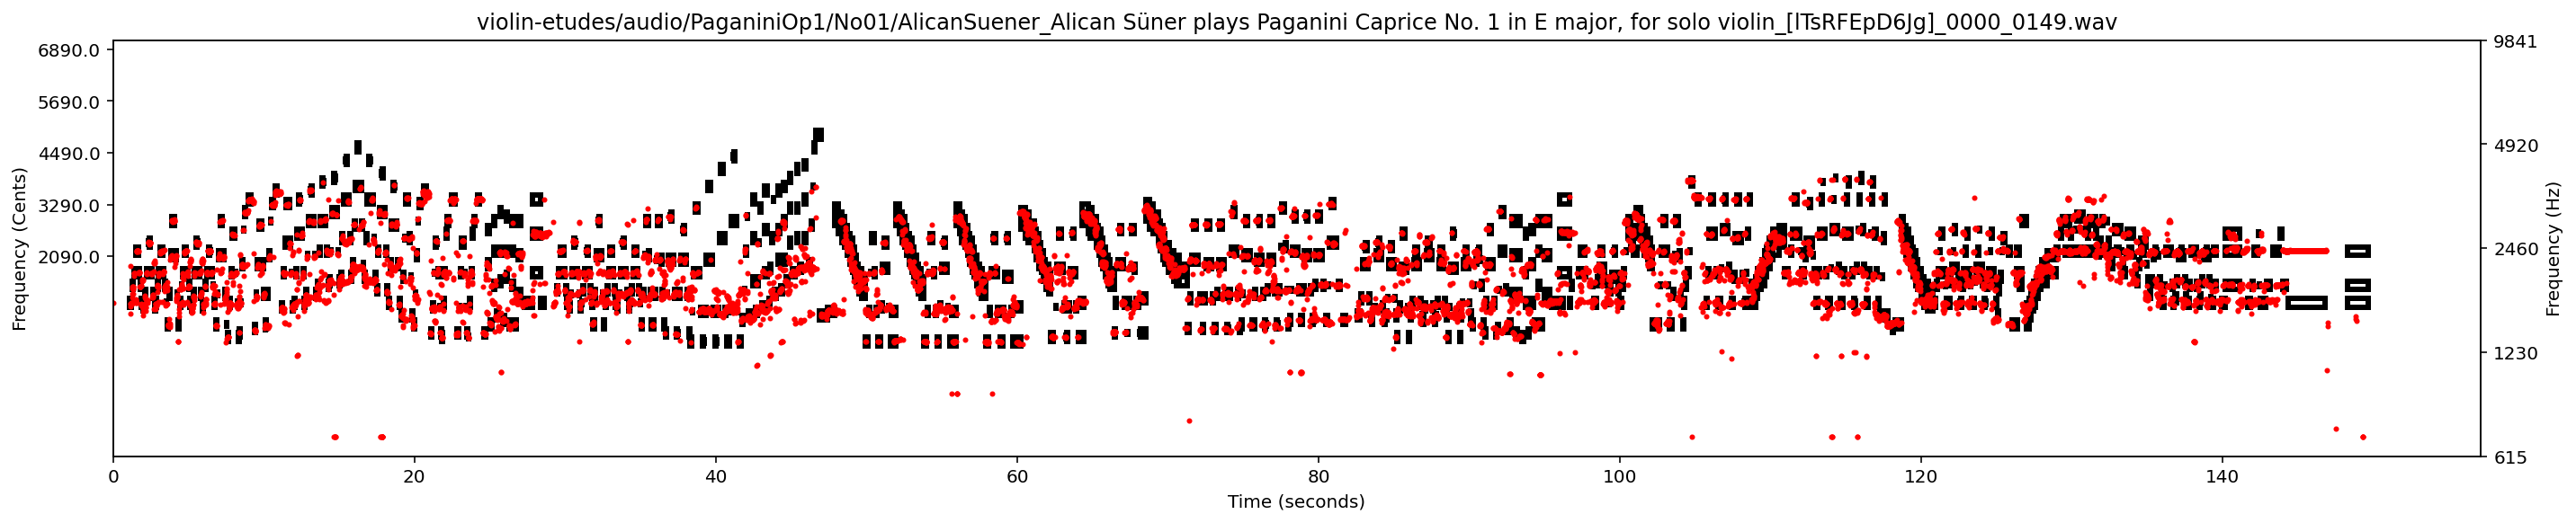

........................................................................................feature extraction successful
alignment successful


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65306 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65372 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127925 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65306 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65372 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127925 missing from current font.
  font.set_te

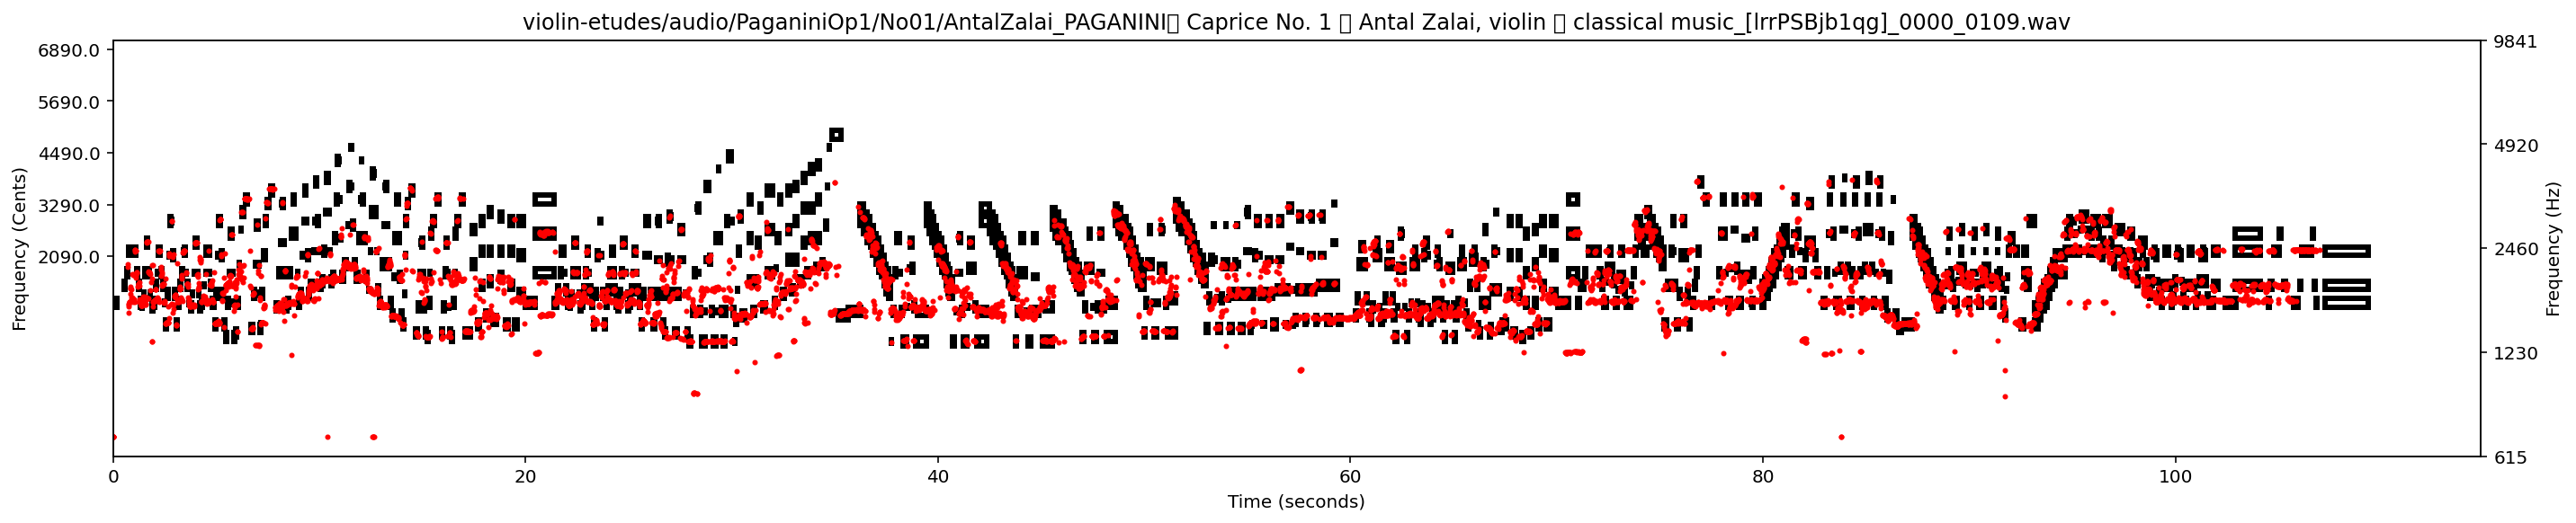

In [14]:
no = 'No01'

midi_path = os.path.join('violin-etudes', 'midi', "PaganiniOp1", 
                          no+'.csv')

recordings = glob.glob(os.path.join('violin-etudes', 'audio', "PaganiniOp1", 
                                    no, '*'))

for audio_path in recordings:
    align_csv(midi_path, audio_path, debug=True, offset=0, duration=None)


# TODO: Now let's align using the new TAPE model (for this we need to use GPU instance)

In [ ]:
!rm -rf tape # remove if the directory already exists
!git clone https://github.com/MTG/tape.git  &> /dev/null
!rm -rf tape/violin/violin_model.pt # the model file is too big for git clone

In [ ]:
!rm -rf tape # remove if the directory already exists
!git clone https://github.com/MTG/tape.git  &> /dev/null
!rm -rf tape/violin/violin_model.pt # the model file is too big for git clone
!pip install mir_eval  &> /dev/null
import gc
import torch
from tape.pitch_estimator import TAPE
from tape.utils import visualize, silence_unvoiced_segments


row = selected_recordings.iloc[0]


window_size=32*1024 
instrument='violin'
hop_length=128
confidence_th=0.8
viterbi=True
batch_size=128

gc.collect()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = TAPE(instrument=instrument, 
              window_size=window_size,
              hop_length=hop_length).to(device)
m, o = row.Method.split('Op')
midi_path = os.path.join('violin-etudes', 'midi', row.Method, 
                          m+'_Opus-'+o+'-'+str(int(row.No[2:]))+'.csv')
f0_path = os.path.join('violin-etudes', 'f0', row.f0Path)
player, key = row.PlayerID, row.YouTubeKey
start, end = row.Start, row.End
audio_name = player+key+str(start)+str(end)
!yt-dlp https://www.youtube.com/watch?v={key} -x --audio-format wav --audio-quality 0   -o "{audio_name}.%(ext)s"  &> /dev/null
print(audio_name, 'downloaded')
audio, sr = librosa.load(audio_name+'.wav', sr=model.sr, offset=start, duration=end-start)
with torch.no_grad():
  time, frequency_our, confidence_our, activation_our = model.predict(torch.tensor(audio), viterbi=viterbi, batch_size=batch_size)


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=19lDroATDKPurK3hTdL6TgntApbiKoWMC
To: /content/tape/violin_model.pt
100%|██████████| 235M/235M [00:00<00:00, 241MB/s]


01YkqQqLPkhcg3109 downloaded


In [ ]:
from score_informed_pitch_detection import convert_ann_to_constraint_region, visualize_salience_traj_constraints, cents_to_hz, hz_to_cents
import pretty_midi
from mir_eval.melody import hz2cents

In [ ]:
df_ann = pd.read_csv(midi_path, sep=';')  # MIDI info
df_ann['start'] += 0.1
df_ann['end'] = df_ann['start'] + df_ann['duration']


In [ ]:
unique_notes = df_ann['pitch'].unique()
F_min = pretty_midi.note_number_to_hz(unique_notes.min())
bin_F_min = np.where(model.labeling.hz2label(F_min)>0)[0][0]
F_max = pretty_midi.note_number_to_hz(unique_notes.max()+1)
bin_F_max = np.where(model.labeling.hz2label(F_max)>0)[0][-1]
F_coef_cents = model.labeling.centers_c[bin_F_min:bin_F_max]
Z = activation_our[:, bin_F_min:bin_F_max] 

In [ ]:
F_max

987.7666025122483

In [ ]:
note_bound_max

53

In [ ]:

hz2cents(np.array([pretty_midi.note_number_to_hz(note)]))[0]

array([7451.31794236])

In [ ]:
note_bound_min

4450.0

(array([125, 126, 127, 128, 129, 130, 131, 132]),)

In [ ]:
midi_roll = Z
hop_ms = time[1]

for note in df_ann['pitch'].unique():
    per_note_df = df_ann[df_ann['pitch'] == note]
    for _, event in per_note_df.iterrows():
        note_cents = hz2cents(np.array([pretty_midi.note_number_to_hz(note)]))[0]
        note_bound_min = note_cents-50  #float: in cents
        note_bound_max = note_cents+50
        note_span = np.where(np.logical_and(F_coef_cents>note_bound_min,
                                            F_coef_cents<note_bound_max))[0]
        note_bound_min = note_span[0] - bin_F_min # int: in label bins
        note_bound_max = note_span[-1] - bin_F_min
        midi_roll[note_bound_min:note_bound_max, 
                  int(event['start'] / hop_ms): int(event['end'] / hop_ms)] = 1

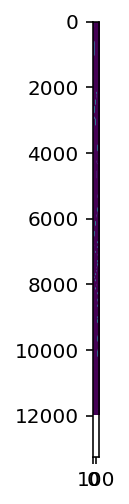

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(midi_roll)

In [ ]:
df_ann = pd.read_csv(midi_path, sep=';')  # MIDI info
df_ann['start'] += 0.1
df_ann['end'] = df_ann['start'] + df_ann['duration']
f_ch_ann = get_features_from_annotation(df_ann)

audio_recording, _ = librosa.load(audio_path, Fs, offset=offset, duration=duration)
_, start_end_indices = librosa.effects.trim(audio_recording)
audio_start = max(start_end_indices[0]/Fs, 10*feature_rate/Fs)   # start and end from librosa effects trim
audio_end = min(start_end_indices[1]/Fs, len(audio_recording)/Fs) # we can also use f0 csv file
f_ch_recording = get_features_from_audio(audio_recording, estimate_tuning(audio_recording, Fs))
print('feature extraction successful')
wp = sync_via_mrmsdtw_with_anchors(f_chroma1=f_ch_ann,
                                    f_chroma2=f_ch_recording,
                                    input_feature_rate=feature_rate,
                                    step_weights=step_weights,
                                    threshold_rec=threshold_rec,
                                    verbose=False,
                                    anchor_pairs=[(0.1, audio_start), (df_ann['end'].max(), audio_end)])
print('alignment successful')
# wp_mono = make_path_strictly_monotonic(wp) this is not improving anything
df_aligned = copy.deepcopy(df_ann)

(13251, 480)